In [1]:
# %matplotlib inline 


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



Selected checkpoint: trainings/AAPL_0.26788_chp.pth

Hyperparameters:
{'CLIPNORM': 1.5,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.2,
 'DROPOUT_SHORT': 0.2,
 'EARLY_STOP_PATIENCE': 7,
 'ETA_MIN': 1e-07,
 'INITIAL_LR': 2e-05,
 'LONG_UNITS': 256,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 100,
 'NUM_WORKERS': 12,
 'PRED_HIDDEN': 128,
 'SHORT_UNITS': 128,
 'TRAIN_BATCH': 64,
 'TRAIN_PREFETCH_FACTOR': 4,
 'T_0': 100,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py:791: UserWarning: No exact checkpoint for sel_val_rmse=0.15130; falling back to minimum RMSE
  warnings.warn(


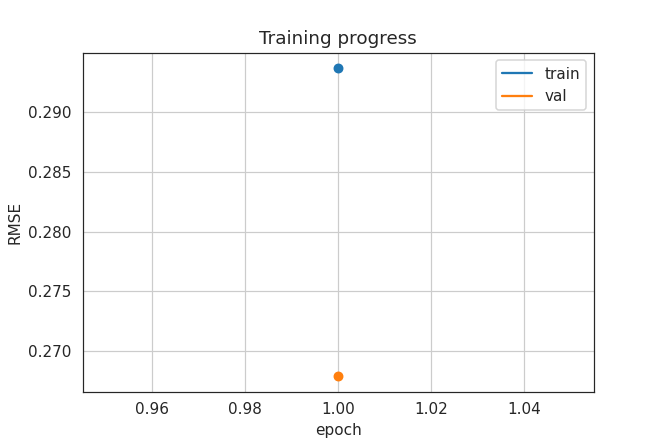


Train metrics: {'rmse': 0.2936830345596955}
 Val metrics: {'rmse': 0.2678767136866555}


ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 64, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.2, inplace=False)
  (short2long): Linear(in_features=128, out_features=256, bias=True)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (pred): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [5]:
device = params.device

model_path = models_core.select_checkpoint(
    models_folder = Path(params.models_folder),
    ticker         = params.ticker,
    sel_val_rmse   = getattr(params, "sel_val_rmse", None)
)
print("Selected checkpoint:", model_path)

# Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model_best = params.model_selected.ModelClass(
    n_feats         = len(params.features_cols_tick),                          
    short_units     = ckpt["hparams"]['SHORT_UNITS'],    
    long_units      = ckpt["hparams"]['LONG_UNITS'],     
    dropout_short   = ckpt["hparams"]['DROPOUT_SHORT'],  
    dropout_long    = ckpt["hparams"]['DROPOUT_LONG'],   
    # att_heads       = ckpt["hparams"]['ATT_HEADS'],
    # att_drop        = ckpt["hparams"]['ATT_DROPOUT'],
    conv_k          = ckpt["hparams"]['CONV_K'],
    conv_dilation   = ckpt["hparams"]['CONV_DILATION'],
    # smooth_k        = ckpt["hparams"]['SMOOTH_K'],
    # smooth_dilation = ckpt["hparams"]['SMOOTH_DILATION']
    pred_hidden      = params.hparams['PRED_HIDDEN'],
)

# Load *only* the weight tensors into that fresh model
model_best.load_state_dict(ckpt["model_state_dict"])
model_best.to(device)

model_best


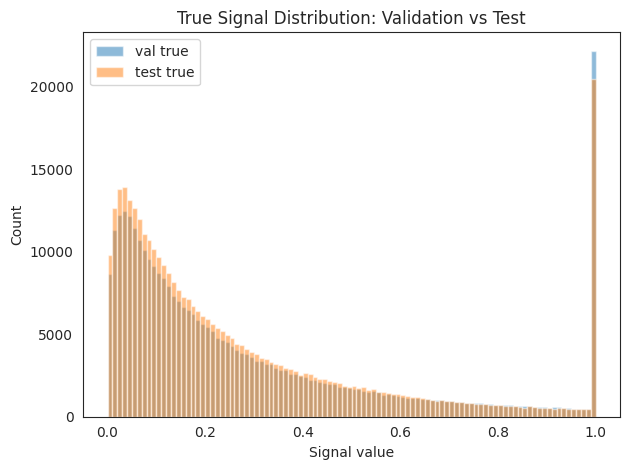

Val baseline: 0.23006853252340415
Test baseline: 0.21032293212347963


In [6]:
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])
y_test = np.concatenate([batch[1].cpu().numpy().ravel() for batch in test_loader])

# Visualize the true‐signal distributions on validation vs. test
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.hist(y_test, bins=100, alpha=0.5, label="test true")

plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Validation vs Test")
plt.legend()
plt.tight_layout()
plt.show()

print("Val baseline:", params.model_selected.compute_baseline(val_loader))
print("Test baseline:", params.model_selected.compute_baseline(test_loader))

In [7]:
importlib.reload(params.model_selected)

# Evaluate each split
train_metrics, train_preds, train_targs, train_times = \
    params.model_selected.eval_on_loader(train_loader, model_best)

val_metrics,   val_preds,   val_targs,   val_times   = \
    params.model_selected.eval_on_loader(val_loader,   model_best)

test_metrics,  test_preds,  test_targs,  test_times  = \
    params.model_selected.eval_on_loader(test_loader,  model_best)


# Simple summary
print("=== SIMPLE SUMMARY ===\n")

print("Predictions lengths:")
print(f"  Train : {len(train_preds)}")
print(f"  Valid : {len(val_preds)}")
print(f"  Test  : {len(test_preds)}\n")

print("Timestamps info:")
print(f"  Train : {len(train_times)} stamps, from {train_times[0]} to {train_times[-1]}")
print(f"  Valid : {len(val_times)} stamps, from {val_times[0]} to {val_times[-1]}")
print(f"  Test  : {len(test_times)} stamps, from {test_times[0]} to {test_times[-1]}\n")

print("Metrics:")
print(f"  Train → RMSE={train_metrics['rmse']:.5f}, MAE={train_metrics['mae']:.5f}, R²={train_metrics['r2']:.5f}")
print(f"  Valid → RMSE={val_metrics['rmse']:.5f}, MAE={val_metrics['mae']:.5f}, R²={val_metrics['r2']:.5f}")
print(f"  Test  → RMSE={test_metrics['rmse']:.5f}, MAE={test_metrics['mae']:.5f}, R²={test_metrics['r2']:.5f}\n")

print("Predictions stats (mean±std):")
print(f"  Train : {train_preds.mean():.5f} ± {train_preds.std():.5f}")
print(f"  Valid : {val_preds.mean():.5f} ± {val_preds.std():.5f}")
print(f"  Test  : {test_preds.mean():.5f} ± {test_preds.std():.5f}")


eval:   0%|          | 0/60 [00:01<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

eval:   0%|          | 0/809 [00:00<?, ?it/s]

=== SIMPLE SUMMARY ===

Predictions lengths:
  Train : 1731840
  Valid : 338701
  Test  : 364859

Timestamps info:
  Train : 245760 stamps, from 2004-01-02T21:00:00.000000000 to 2019-04-04T21:00:00.000000000
  Valid : 751 stamps, from 2019-04-05T21:00:00.000000000 to 2022-03-28T21:00:00.000000000
  Test  : 809 stamps, from 2022-03-29T21:00:00.000000000 to 2025-06-18T21:00:00.000000000

Metrics:
  Train → RMSE=0.26807, MAE=0.18867, R²=0.14826
  Valid → RMSE=0.26788, MAE=0.18654, R²=0.12890
  Test  → RMSE=0.25762, MAE=0.18166, R²=0.12687

Predictions stats (mean±std):
  Train : 0.22022 ± 0.11696
  Valid : 0.21276 ± 0.12006
  Test  : 0.21581 ± 0.11728


In [8]:
# Train metrics: {'rmse': 0.25841525197029114, 'mae': 0.21155734360218048, 'r2': 0.20853853225708008, 'acc': 0.7583431601524353, 'prec': 0.6355187892913818, 'rec': 0.29646870493888855, 'f1': 0.4043217897415161, 'auroc': 0.7376400232315063}
#  Val metrics: {'rmse': 0.2514066994190216, 'mae': 0.19861817359924316, 'r2': 0.23272109031677246, 'acc': 0.7520084381103516, 'prec': 0.6640623211860657, 'rec': 0.27688372135162354, 'f1': 0.39081525802612305, 'auc': 0.7395428419113159, 't_acc': 0.3100847899913788, 't_prec': 0.3333747982978821, 't_rec': 0.3100847899913788, 't_f1': 0.07097241282463074, 't_auc': 0.48658663034439087}

In [9]:
def add_preds_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    end_times_tr:  np.ndarray,
    end_times_val: np.ndarray,
    end_times_te:  np.ndarray
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stamp per-window regression predictions into a minute-bar DataFrame and split.

    Safety and behavior notes:
    - Validates preds lengths match corresponding timestamp arrays.
    - Coerces timestamps with pd.to_datetime and aligns timezones with df.index:
      * if df.index has tz and timestamps are naive => localize timestamps to df.index.tz
      * if df.index is naive and timestamps are tz-aware => convert timestamps to naive
    - Converts preds to 1D numpy arrays.
    - If duplicate timestamps appear in a preds series, keeps the LAST value (warns).
    - Warns about timestamps not found in df.index and stamps only intersecting indices.
    - Returns (df_trainval, df_test) with rows where 'pred_signal' is present.
    """
    df2 = df.copy()
    df2["pred_signal"] = np.nan

    # helper: validate & build Series (1D preds, DatetimeIndex aligned to df.index tz)
    def _make_series(preds, times, label):
        preds = np.asarray(preds).ravel()
        if len(preds) != len(times):
            raise ValueError(f"{label}: preds length {len(preds)} != times length {len(times)}")
        # coerce times to datetime
        idx = pd.to_datetime(times)
        # align timezones with df.index
        tz_df = getattr(df.index, "tz", None)
        tz_ts = getattr(idx, "tz", None)
        if tz_df is not None and tz_ts is None:
            idx = idx.tz_localize(tz_df)
        elif tz_df is None and tz_ts is not None:
            idx = idx.tz_convert(None)
        # build series
        s = pd.Series(preds, index=pd.DatetimeIndex(idx))
        # handle duplicates by keeping last (change to .mean() if preferred)
        if s.index.has_duplicates:
            ndup = s.index.duplicated().sum()
            print(f"⚠️ {label}: {ndup} duplicate timestamps found; keeping last value for each timestamp")
            s = s[~s.index.duplicated(keep="last")]
        return s

    s_tr  = _make_series(train_preds, end_times_tr,  "Train")
    s_val = _make_series(val_preds,   end_times_val,  "Val")
    s_te  = _make_series(test_preds,  end_times_te,  "Test")

    def _stamp(series: pd.Series, label: str):
        missing = series.index.difference(df2.index)
        if not missing.empty:
            print(f"⚠️ {label}: {len(missing)} timestamps not found in DataFrame")
        valid = series.index.intersection(df2.index)
        if not valid.empty:
            df2.loc[valid, "pred_signal"] = series.loc[valid].values

    _stamp(s_tr,  "Train")
    _stamp(s_val, "Val")
    _stamp(s_te,  "Test")
    print(f"✅ Stamped {len(s_tr)} Train, {len(s_val)} Val, {len(s_te)} Test predictions")

    # build indices for split, only keep rows where pred_signal is not NaN
    idx_trval = s_tr.index.union(s_val.index).intersection(df2.index)
    idx_te    = s_te.index.intersection(df2.index)

    df_trainval = df2.loc[idx_trval].dropna(subset=["pred_signal"])
    df_test     = df2.loc[idx_te].dropna(subset=["pred_signal"])

    print(f"➡️  train+val: {len(df_trainval)} rows, test: {len(df_test)} rows")
    return df_trainval, df_test


In [10]:
# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = add_preds_and_split(
    df            = df_feat_sel,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

# 2) Persist CSVs
print("Saving test CSV…")
df_test.to_csv(params.test_csv)
print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)

df_test

✅ Stamped 1731840 Train, 338701 Val, 364859 Test predictions
➡️  train+val: 2070541 rows, test: 364859 rows
Saving test CSV…
Saving train+val CSV…


,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal,pred_signal
2022-03-29 13:30:00,0.652690,0.200398,0.688024,0.425284,0.280388,0.086049,0.535660,0.194285,0.919924,0.449214,0.636790,0.950996,0.429308,0.289483,0.526836,0.448311,0.338562,176.890,0.126781,0.381210
2022-03-29 13:31:00,0.613389,0.189182,0.672561,0.433368,0.275827,0.036882,0.537671,0.191125,0.821991,0.474546,0.633943,0.945358,0.443920,0.256181,0.526122,0.448311,0.327336,176.870,0.089210,0.384270
2022-03-29 13:32:00,0.591864,0.183761,0.676476,0.438343,0.263666,0.097118,0.540121,0.221208,0.738799,0.512564,0.631524,0.937933,0.458115,0.247135,0.522312,0.448311,0.310210,176.880,0.067235,0.379249
2022-03-29 13:33:00,0.534374,0.177865,0.635556,0.419483,0.258788,0.086078,0.542131,0.212277,0.633100,0.436527,0.628447,0.916070,0.438420,0.233643,0.522153,0.448311,0.295104,176.830,0.080207,0.389822
2022-03-29 13:34:00,0.549318,0.178447,0.657845,0.402997,0.239452,0.159814,0.542787,0.236648,0.577845,0.563272,0.626838,0.905016,0.460270,0.250007,0.519522,0.448311,0.274446,176.880,0.110511,0.377726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815,0.684908,0.356595
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675,0.612206,0.417718
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670,0.610468,0.458961
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240,0.477090,0.382789


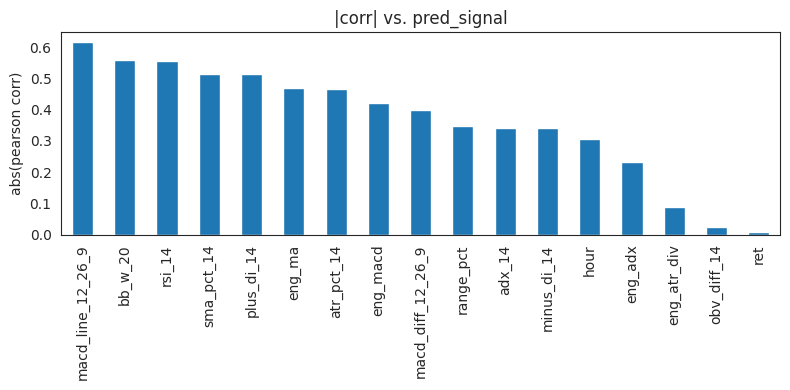

macd_line_12_26_9    0.616321
bb_w_20              0.557648
rsi_14               0.555254
sma_pct_14           0.514780
plus_di_14           0.513890
eng_ma               0.468155
atr_pct_14           0.466052
eng_macd             0.422485
macd_diff_12_26_9    0.398961
range_pct            0.345888
adx_14               0.341480
minus_di_14          0.339556
hour                 0.307322
eng_adx              0.231467
eng_atr_div          0.087936
obv_diff_14          0.023008
ret                  0.009100
dtype: float64

In [11]:
# Quick correlation check
# This measures the absolute Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_raw")
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

In [ ]:
# importlib.reload(feats) #############

# — Integrated-Gradients (Captum) AFTER add_preds_and_split and loading model_best —
feature_names = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_raw")
]

imp_df = feats.ig_feature_importance(
    model_best,
    test_loader,
    feature_names,
    device,
    n_samples=20,    # how many windows to sample
    n_steps=10       # fewer steps → less mem & time
)

# Simple horizontal bar plot
plt.figure(figsize=(6,8))
imp_df \
    .set_index("feature")["importance"] \
    .sort_values() \
    .plot.barh(color="C0")
plt.title("IG Feature Importances")
plt.xlabel("Average |attribution| over time")
plt.tight_layout()
plt.show()

imp_df


IG windows:   0%|          | 0/20 [00:00<?, ?it/s]

/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py:736: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
# Compute Descriptive Statistics
# Statistics show whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

In [ ]:
# pick a random trading day from the test set
all_days = df_test.index.normalize().unique()
day      = np.random.choice(all_days)

# mask for that day
mask = df_test.index.normalize() == day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(params) ##########

# Create 'ask' and 'bid' columns using the given spread 
df_test['ask'] = round(df_test['close_raw'] * (1 + params.bidask_spread_pct/100), 4)
df_test['bid'] = round(df_test['close_raw'] * (1 - params.bidask_spread_pct/100), 4)

# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.
# Simulate per‐day to avoid cross‐midnight state carry‐over
sim_results = {}

groups     = list(df_test.groupby(df_test.index.normalize()))
print(f"Processing {len(groups)} days of predictions…")

for day, df_day in tqdm(groups, desc="Generate+Simulate"):
    # a) Generate discrete actions from the continuous signal
    df_actions = trades.generate_trade_actions(
        df                = df_day,
        col_signal        = "pred_signal", # name for the signal column to use
        col_action        = "pred_action", # name for the trade-action column to add
        buy_threshold     = params.pred_threshold_tick,
        trailing_stop_pct = params.trailing_stop_pred_tick,
        sess_start        = params.sess_start,
        col_close         = "close_raw",    # name of the column to use for price
    )

    # b) Run the backtest on this single‐day DataFrame
    single_result = trades.simulate_trading(
        results_by_day_sign = {day: (df_actions, [])},
        col_action          = "pred_action",
        sess_start          = params.sess_start,
        sess_end            = params.sess_end
    )
    sim_results.update(single_result)

# final: sim_results holds each day → (df_sim, trades, stats)


In [ ]:
year, month = map(int, params.month_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

feat_sel = [f for f in df_feat_sel.columns if f not in ('bid', 'ask', params.label_col)]

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {params.month_to_check}")
else:
    print(f"\nPlotting days in {params.month_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats,
            col_close         = 'close_raw',
            features          = feat_sel
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")
        print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == params.month_to_check]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)